In [1]:
import glob
import numpy as np
import astropy.units as u
from astropy.time import Time
from astropy.constants import c

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

%matplotlib inline

In [18]:
import dynspectools as dtools
import normsspectools as ns

# Load our dynamic spectrum

## If you are instead starting directly from a dynamic spectrum (.dspec), go to "Let's measure the size of scintles"  use dtools.read_psrflux()

The archive is a data cube of dimensions [time, pol, frequency, phase].  Typical pulsar diagnostic plots show t vs. phase and phase vs. frequency.  

We are after the "dynamic spectrum", which is simply the time vs. frequency.

For this tutotial we will ignore polarization.  The pols are ordered XX*, YY*, Re(XY*), Im(XY*) (or L and R if feeds are circular), so we sum the 0 and 1 pols to form the total intensity.



Text(0, 0.5, 'frequency (bins)')

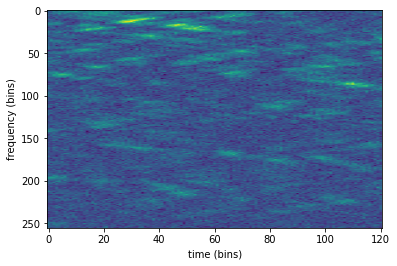

In [128]:
"""
If you are reading from a .dspec file, the above steps can be skipped.  
Use this function to read in your dynspec

"""

fname = 'data/simpsr_59448.91423261261.dynspec'
dynspec, dserr, T, F, psrname = dtools.read_psrflux(fname)

plt.imshow(dynspec.T, aspect='auto')
plt.xlabel('time (bins)')
plt.ylabel('frequency (bins)')

In [129]:
"""
Look at details of the observation
"""

t0 = Time(T[0], format='mjd')
tend = Time(T[-1], format='mjd')
Tobs = tend.unix - t0.unix
BW = F[-1] - F[0]

print("data shape is {0}".format(dynspec.shape))

print("Start time is {0}".format(t0.isot))

print("Observation Length is {0}s".format(Tobs) )

print("Frequency range is {0} - {1}".format(min(F), max(F)) )

data shape is (121, 256)
Start time is 2021-08-22T21:57:29.698
Observation Length is 14400.0s
Frequency range is 1400.0 MHz - 1449.8046875 MHz


# Let's measure the characteristic time and frequency size of scintles

We will do this using the 2D Autocorrelation Function

To do this, we FFT, multiply, and iFFT the dynamic spectrum 

Remember convolution theorem - the dynspecs are multiplied in Fourier space, so they are convolved when IFTed


df = 0.6638570034575874 +- 0.027028898708146978 MHz
dt = 736.4002039128086 +- 8.490392695441187, seconds


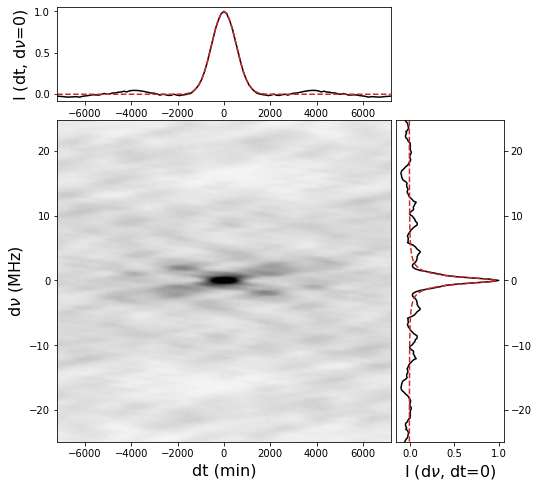

In [130]:
from scipy.optimize import curve_fit

def Gaussian(x, sigma, A, C):
    return A*np.exp( -x**2 / (2*sigma**2) ) + C

def Lorentzian(x, gamma, A, C):
    return A* ( (0.5*gamma) / ( x**2 + (0.5*gamma)**2 ) ) + C

ccorr = np.fft.ifft2( np.fft.fft2(dynspec) * np.fft.fft2(dynspec).conj() )
# Im values are 0 anyways, so take the absolute value or real values
ccorr = abs(ccorr)

# Take slice through center of cross-correlation along frequency axis
# Ignoring zero component with noise-noise correlation
ccorr_f = ccorr[1] + ccorr[-1]
ccorr_f -= np.median(ccorr_f)
ccorr_f /= np.max(ccorr_f)
ccorr_f = np.fft.fftshift(ccorr_f)

# Take slice through center of cross-correlation along time axis
# Ignoring zero component with noise-noise correlation
ccorr_t = ccorr[:,1] + ccorr[:,-1]
ccorr_t -= np.median(ccorr_t)
ccorr_t /= np.max(ccorr_t)
ccorr_t = np.fft.fftshift(ccorr_t)

# Get the correct units
BW = (max(F) - min(F)).value
df_axis = np.linspace(-BW/2., BW/2., len(F), endpoint=False)
dt_axis = np.linspace(-Tobs/2., Tobs/2., len(T), endpoint=True)

# Fit the slices in frequency and time with a Gaussian
# p0 values are just a starting guess
p0 = [5., 1, 0]
popt, pcov = curve_fit(Lorentzian, df_axis, ccorr_f, p0=p0)

nuscint = abs(popt[0])
nuscint_err = np.sqrt(pcov[0,0])

#fscint =  np.sqrt(2*np.log(2)) * nuscint
#fscinterr =  np.sqrt(2*np.log(2)) * nuscint_err 
fscint = nuscint / 2.
fscinterr = nuscint_err / 2.

pT = [1000., 1, 0]
poptT, pcovT = curve_fit(Gaussian, dt_axis, ccorr_t, p0=pT)
tscint = np.sqrt(2) * abs(poptT[0])
tscinterr = np.sqrt(2) * np.sqrt(pcovT[0,0])

# Find nice vmax, vmin values for plotting
vmax = np.mean(ccorr) + 10*np.std(ccorr)
vmin = np.mean(ccorr) - 3*np.std(ccorr)


plt.figure(figsize=(8,8))

ax1 = plt.subplot2grid((4, 4), (1, 0), colspan=3, rowspan=3)
ax2 = plt.subplot2grid((4, 4), (1, 3), rowspan=3)
ax3 = plt.subplot2grid((4, 4), (0, 0), colspan=3)

plt.subplots_adjust(wspace=0.05)

ax1.imshow(np.fft.fftshift(ccorr).T, aspect='auto', origin='lower',
          extent=[min(dt_axis), max(dt_axis), min(df_axis), max(df_axis)],
          vmax=vmax, vmin=vmin, cmap='Greys')

ax1.set_xlabel('dt (min)', fontsize=16)
ax1.set_ylabel(r'd$\nu$ (MHz)', fontsize=16)

ax2.plot( ccorr_f, df_axis, color='k')
ax2.plot(Lorentzian(df_axis, *popt), df_axis, color='tab:red',
        linestyle='--')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel(r'I (d$\nu$, dt=0)', fontsize=16)
ax2.set_ylim(min(df_axis), max(df_axis) )

ax3.plot( dt_axis, ccorr_t, color='k')
ax3.plot( dt_axis, Gaussian(dt_axis, *poptT), color='tab:red',
          linestyle='--')
ax3.set_ylabel(r'I (dt, d$\nu$=0)', fontsize=16)
ax3.set_xlim(min(dt_axis), max(dt_axis))

print("df = {0} +- {1} MHz".format(fscint, fscinterr))
print("dt = {0} +- {1}, seconds".format(tscint, tscinterr))


# Look at Secondary Spectrum

The secondary spectrum is the squared modulus of the 2D FFT of the dynamic spectrum

It expresses the power in terms of the time delay and fringe rate between all pairs of interfering images

In [ ]:
# Plotting choices, fiddle to look good
bintau = 2
binft = 1
vm = 3.
xlim = 0
ylim = 0

df = (F[1] - F[0])
dt = (T[1] - T[0]).to(u.s)

CS = np.fft.fft2(dynspec)
S = np.abs(np.fft.fftshift(CS))**2.0    

Sb = S.reshape(-1,S.shape[1]//bintau, bintau).mean(-1)
if binft > 1:
    nftbin = Sb.shape[0]//binft
    print(Sb.shape)
    Sb = Sb[:binft*nftbin].reshape(nftbin, binft, -1).mean(1)
Sb = np.log10(Sb)

# Calculate the conjugate frequencies (time delay, fringe rate), only used for plotting
ft = np.fft.fftfreq(S.shape[0], dt)
ft = np.fft.fftshift(ft.to(u.mHz).value)

tau = np.fft.fftfreq(S.shape[1], df)
tau = np.fft.fftshift(tau.to(u.microsecond).value)    

slow = np.median(Sb)-0.2
shigh = slow + vm

# Not the nicest, have a set of different plots it can produce
plt.figure(figsize=(5,8))

# Plot Secondary spectrum
plt.imshow(Sb.T, aspect='auto', vmin=slow, vmax=shigh, origin='lower',
           extent=[min(ft), max(ft), min(tau), max(tau)], interpolation='nearest',
          cmap='viridis')
plt.xlabel(r'$f_{D}$ (mHz)', fontsize=16)
plt.ylabel(r'$\tau$ ($\mu$s)', fontsize=16) 

if xlim:
    plt.xlim(-xlim, xlim)
if ylim:
    plt.ylim(-ylim, ylim)

# All together, single command

df = 0.7140464559130161 +- 0.19746062349288987 MHz
dt = 947.8486529850047 +- 7.233527830472237, seconds


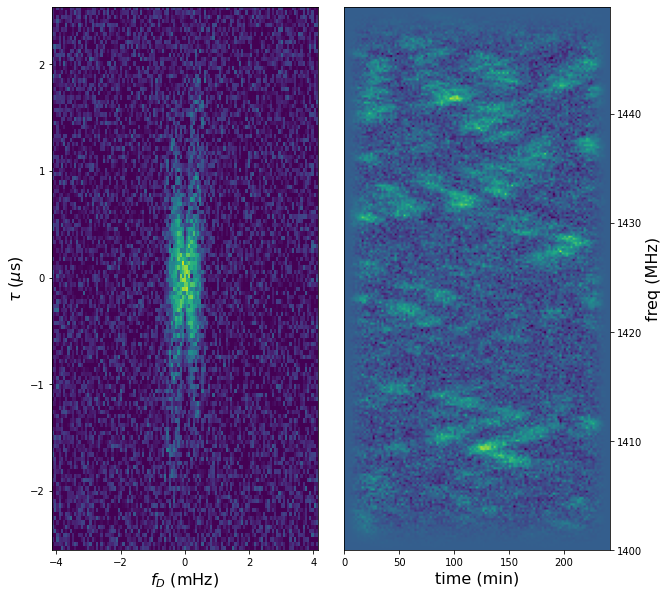

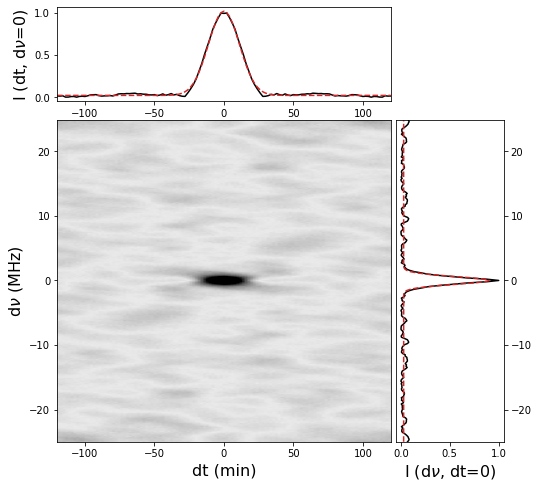

In [100]:
CS, ft, tau = dtools.plot_secspec(dynspec, F.value, dt=dt, binft=binft,
                       bintau=bintau, vm=3.)

ccorr, fscint, fscinterr, tscint, tscinterr = dtools.Gaussfit(dynspec, df, dt)

print("df = {0} +- {1} MHz".format(fscint, fscinterr))
print("dt = {0} +- {1}, seconds".format(tscint, tscinterr))

# Measuring arc curvatures: overplotting parabolae, or using "Normalized Secondary Spectrum"

13.778276707874543 km / (kpc(1/2) s)


(-2.56, 2.54)

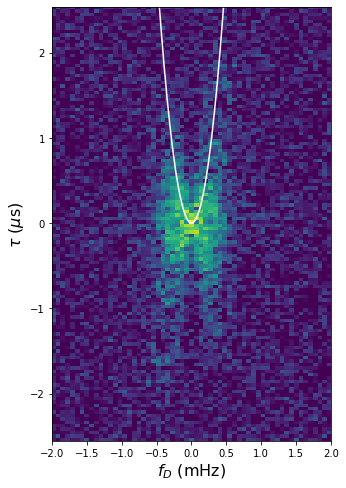

In [114]:
# zoom in plot to certain ftlim
# Overplot parabola of given curvature eta (units in mus / mHz^2 = s^3)
eta = 12.

xlim = 2.
ftplot = np.linspace(-xlim, xlim, 200)

# Corresponding veff/sqrt(deff) from eta
fref = np.mean(F)
lam = (c / fref).to(u.cm)

W = lam / np.sqrt(2*c*eta*u.s**3)
W = W.to(u.km/u.s/u.kpc**0.5)
print(W)

plt.figure(figsize=(5,8))

# Plot Secondary spectrum
plt.imshow(Sb.T, aspect='auto', vmin=slow, vmax=shigh, origin='lower',
           extent=[min(ft), max(ft), min(tau), max(tau)], interpolation='nearest',
          cmap='viridis')
plt.xlabel(r'$f_{D}$ (mHz)', fontsize=16)
plt.ylabel(r'$\tau$ ($\mu$s)', fontsize=16) 

plt.plot(ftplot, eta*ftplot**2, color='w')

if xlim:
    plt.xlim(-xlim, xlim)
plt.ylim(min(tau), max(tau))

/home/ramain/packages/FundiScintTutorial2023/normsspectools.py:24: RuntimeWarning: divide by zero encountered in true_divide
  curvaxis = tauref / (xgrid)**2.0


95.15480015283951 134.54250907999545
The best fit curvature is 95.15480015283951+-134.54250907999545
The best fit scaled effective velocity is 4.892943204826773 km / (kpc(1/2) s)+-3.459146855996332 km / (kpc(1/2) s)


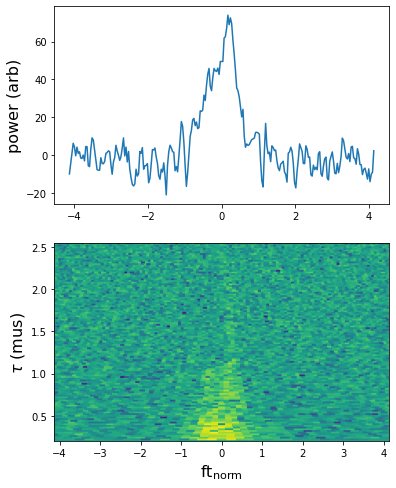

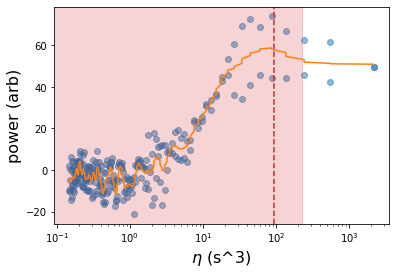

In [118]:
Ngrid = 2*len(ft)
taumin = 0.2
Sbg = np.log10(S)
Sbg = Sbg - np.mean(Sbg, axis=0)
Snorm, ftnormaxis, curvaxis = ns.norm_sspec(Sbg, ft, tau, Ngrid=Ngrid, taumin=taumin)
Sprof = Snorm.sum(1)

plt.figure(figsize=(6, 8))

plt.subplot(211)
plt.plot(ftnormaxis, Sprof)
plt.ylabel('power (arb)', fontsize=16)

plt.subplot(212)
plt.imshow(Snorm.T, origin='lower', aspect='auto',
          extent=[min(ftnormaxis), max(ftnormaxis), min(tau), max(tau)])
plt.ylim(taumin, max(tau))

plt.xlabel(r'ft$_{\rm norm}$', fontsize=16)
plt.ylabel(r'$\tau$ (mus)', fontsize=16)


ieta = np.argsort(curvaxis)
eta_ax = curvaxis[ieta]
I_eta = Sprof[ieta]
I_etasmooth = gaussian_filter(I_eta, 2)

plt.figure()
plt.scatter(eta_ax, I_eta, alpha=0.5)
plt.plot(eta_ax, I_etasmooth, color='tab:orange')

plt.xscale('log')
# Take lim around the peak, fit with e.g. a parabola to measure peak

plt.ylabel('power (arb)', fontsize=16)
plt.xlabel(r'$\eta$ (s^3)', fontsize=16)

imax = np.argmax(I_etasmooth)
etapeak = eta_ax[imax]
Ipeak = I_etasmooth[imax]
etarange = 0.3
fitrange = np.argwhere( (eta_ax > etarange*etapeak) & (eta_ax < etapeak/etarange) ).squeeze()
I_fit = I_eta[fitrange]
eta_fit = eta_ax[fitrange]

p0 = [etapeak, -Ipeak, Ipeak]

yfit, eta, eta_err = ns.fit_log_parabola(eta_fit, I_fit)
plt.axvline(eta, color='tab:red', linestyle='--')
plt.axvspan(eta-eta_err, eta+eta_err, color='tab:red', alpha=0.2)

print(eta, eta_err)
W = lam / np.sqrt(2*c*eta*u.s**3)
W = W.to(u.km/u.s/u.kpc**0.5)

Werr = lam / (2*np.sqrt(2*c)) * (eta*u.s**3)**(-3/2.) * eta_err*u.s**3
Werr = Werr.to(u.km/u.s/u.kpc**0.5)

print("The best fit curvature is {0}+-{1}".format(eta, eta_err))
print("The best fit scaled effective velocity is {0}+-{1}".format(W, Werr) )
